### Real Estate Label Classification along with approximate nearest neighbor search to find similar images in each category

Here, we intend to understand the current real estate classification model build by cohort 13. We start by training resnet50 model on 7 predefined categories. The dataset was collected by previous cohorts . The dataset was uploaded on google drive for easy loading. Additionally, we try to reimplement annoy search on small set to find similar images

**Import Libraries**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks"
base_dir = root_dir + '/fellowship.ai/'

Mounted at /content/gdrive


**Getting the data**

Initially, we only use a small subset of dataset to train the model in order to see how performs for less number of images

In [0]:
PATH = Path(base_dir+'realestate/data/train/') 

In [0]:
# create a image list from folder path
data = (ImageList.from_folder(PATH).split_subsets(train_size = 0.05, valid_size = 0.01,seed=42).label_from_folder()
      .transform(get_transforms(), size=224)
           .databunch(bs=64).normalize(imagenet_stats))

In [0]:
# number of classes
print(f'Dataset has {data.c} classes: {data.classes}')

Dataset has 8 classes: ['Exterior', 'Interior', 'bath_copy', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

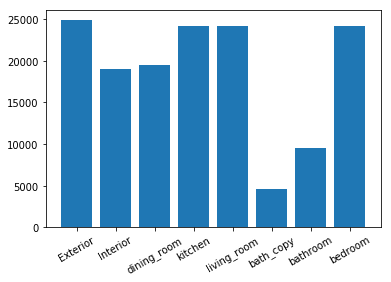

In [0]:
# get class wise distribution of images evaluated on entire data
class_count = {}
for root, dirs , files in os.walk(PATH, topdown=False):
  root = root.split('/')[-1]
  if root in data.classes:
      class_count[root] = len(files)
plt.bar(class_count.keys(), class_count.values())
plt.xticks(rotation=30)

From above, we see that there are approximately 23000 for each class except for bathroom and bath_copy. I guess bath_copy is augmented version of bathroom, done in order to have balanced classes. For classifying using entire data, bath_copy would be merged with bathroom data

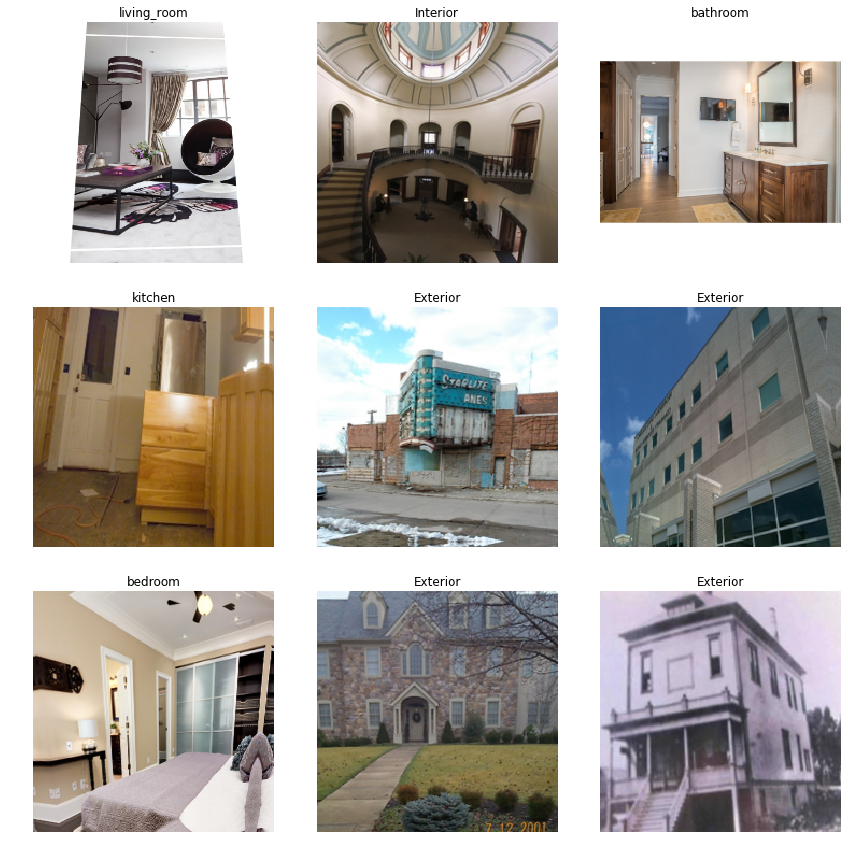

In [0]:
data.show_batch(rows=3)

**Training resnet50**

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 68360217.50it/s]


We use lr finder to to find value where steepest slope starts. This would be max-lr

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


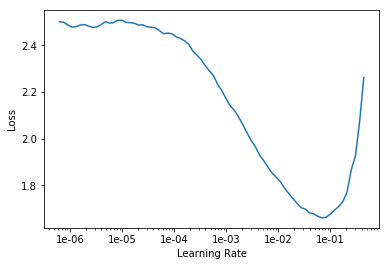

In [0]:
learn.lr_find()
learn.recorder.plot()

Initially we fit the model using transfer learning for small number of epochs  to observe model convergence

epoch,train_loss,valid_loss,accuracy,time
0,0.946228,0.676672,0.760507,19:11
1,0.708233,0.515226,0.819880,02:38
2,0.546011,0.471043,0.830554,02:39


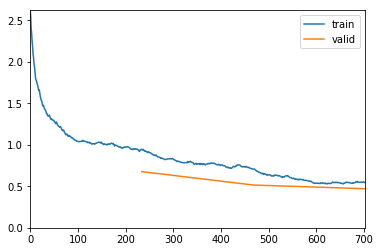

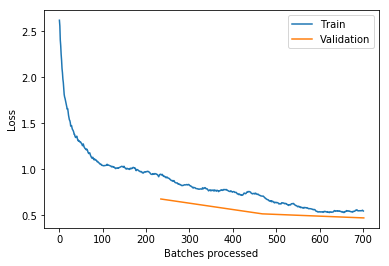

In [0]:
learn.fit_one_cycle(3,max_lr=slice(1e-03))
learn.recorder.plot_losses()

On a small dataset, the model seems to converge well. So i haven't perform further training yet. As next step, i try to use annoy for finding similar images 

**Annoy Search**

Annoy is excellent library developed by spotify to find similar images using approximate nearest neighbor search. In order to do this, neural network is trained first to find best features, which we did above. Next, we use these features to find images with similar patterns. The Neural net features can be extracted from the penultimate layer of the network. To implement this, fast.ai's hook functionality which allows us to save the activations of any layer.

In [0]:
def get_activations(m, x):
    "Return activations of the penultimate layer after forward pass of an image through CNN"
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[0]) as hook_a: 
        preds = m(xb)
    acts  = hook_a.stored[0].cpu()
    return acts

In [0]:
def create_subdata(ds, size=1000, seed=42):
    "Returns a subset of the dataset"
    sub_ds = []
    np.random.seed(seed)
    for i in range(size):
        idx = np.random.randint(0, 100000)
        x, y = ds[idx]
        sub_ds.append({'x': x, 'y': y})
    return sub_ds

We again choose a smaller subset, since as per previous cohort, annoy takes lot a of memory

In [0]:
# sub_ds = create_subdata(data.train_ds, seed=30)
sub_ds = data.train_ds

In [0]:
# get the flattened activations from the penultimate layer of the CNN for images
x_new = []
m = learn.model.eval()
for idx in range(len(sub_ds)):
    x = sub_ds[idx][0]
    y = sub_ds[idx][1]
    x_new.append(get_activations(m, x).mean(1).mean(1).flatten())
    
new_dims = len(x_new[0])
print(f'Dimensions of the activations (penultimate layer): {new_dims}')

Dimensions of the activations (penultimate layer): 2048


In [0]:
x_new[0].shape

torch.Size([2048])

In [0]:
# create index of the all the images (reduced space)
f = new_dims
t = AnnoyIndex(f)
for i, x in enumerate(x_new):
    t.add_item(i, x)
# build 100 trees. More number of trees means higher precision (requires higher RAM)
t.build(n_trees=100)   
# save the index on the disk for reuse later
t.save('realestate-sample-index.ann')

True

In [0]:
# Load the saved annoy index
f = 2048
index = AnnoyIndex(f)
index.load('realestate-sample-index.ann') # super fast, will just mmap the file

True

In [0]:
# function to search for similar images using annoy and plot them
def plot_similar(idx, train_ds, test_ds, annoy_index, k=5):
    "Search and Plot `k` similar images for given image using approx. nearest neighbor search (annoy)"
    x = test_ds.x[idx]
    
    # get activations for the image
    v = get_activations(m, x).mean(1).mean(1).flatten()

    # get 5-nearest neighbor
    x_sim = annoy_index.get_nns_by_vector(v, k)
    print(f'{k} images most similar to {idx} (test set) are {x_sim} (train set)')
    
    # plotting the similar images
    n = 1+len(x_sim)
    plt.figure(figsize=(100, 10))
    ax = plt.subplot(1, n, 1)
    im = show_image(x, ax)
    im.set_title(f'Test Image: {test_ds.y[idx]}')
    for i, j in enumerate(x_sim):
        ax = plt.subplot(1, n, i+2)
        im_sim = show_image(train_ds[j][0], ax)
        im_sim.set_title(f"{train_ds[j][1]}")

5 images most similar to 140 (test set) are [3755, 5003, 4408, 3050, 7386] (train set)


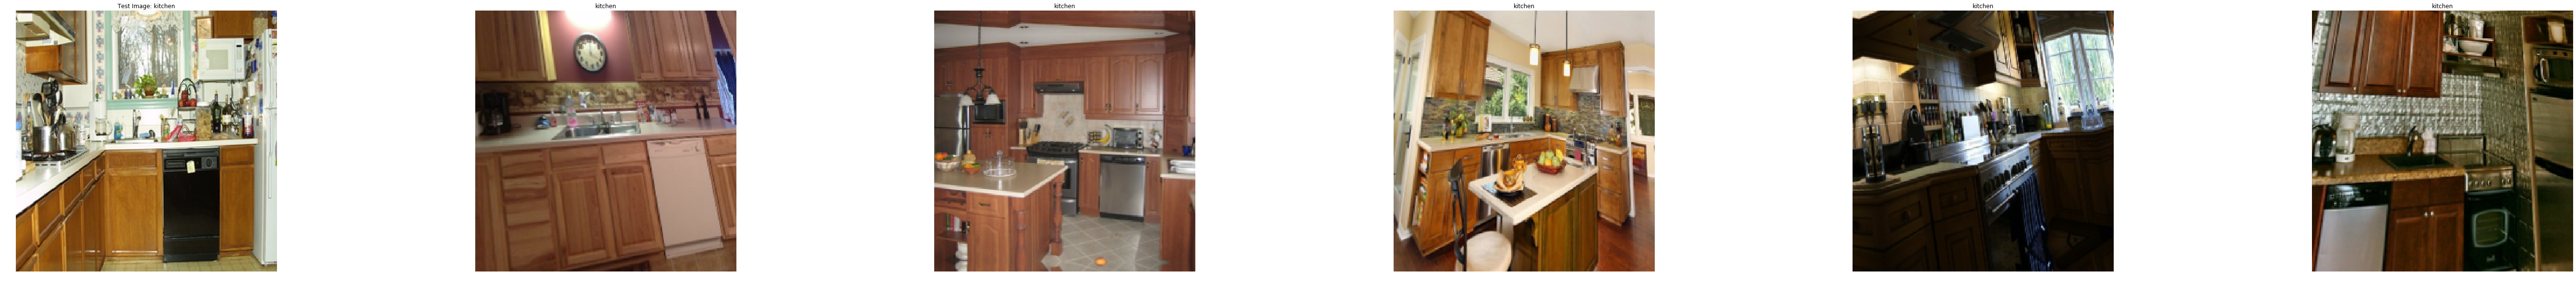

In [0]:
idx = 140
plot_similar(idx, train_ds=sub_ds, test_ds=data.valid_ds, annoy_index=index)

From above, i deduce that, annoy gives pretty good similar images even though the model was trained for small subset of images. I learned that this can be used to find more dataset for new set of categories

I din't work on entire data, since the classification was already done by cohort13. Here,  I intend to add few rich labelled dataset to current dataset and train the current model on newer data using transfer learning. The dataset for rich attributes will be taken from PLACES dataset. I have already collected few rich labelled dataset - Patio, Alove, Utility Room, Storage Room, balcony